In [1]:

# Q-LEARNING TRAFFIC SIGNAL CONTROL 
import traci
import numpy as np
import random
from collections import defaultdict
import pickle

#declaring path to acces files and to save q value
SUMO_BINARY = r"C:\Program Files (x86)\Eclipse\Sumo\bin\sumo.exe"
SUMO_CFG = r"C:\Users\OMEN\Downloads\test\test1.sumocfg"
Q_SAVE_PATH = "q_table2.pkl"

#these are training parameters
MAX_EPISODES = 1000
MAX_STEPS = 600

ALPHA = 0.2
GAMMA = 0.9

EPSILON = 1.0
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.05

MIN_GREEN = 5



Q = defaultdict(lambda: np.zeros(2))   #starting q is null but if you try to acces q[key] then create a {...,key:[0,0]} only if key is not there in dic, Q table, actions: [continue, switch] Q[state] → array of action values, actions = [0, 1], 0 → continue, 1 → switch
                                       #Q[state] -> [x, y] ,x = value of action 0 (continue) in this state ,y = value of action 1 (switch) in this state

# reset enviroment (with random seed)-after each episode we end the simulation and start other one with diff seed(for randomness)
def reset_sumo(seed):
    if traci.isLoaded():
        traci.close()

    traci.start([
        SUMO_BINARY,
        "-c", SUMO_CFG,
        "--seed", str(seed),          
        "--no-step-log",
        "--quit-on-end"
    ])

    traci.simulationStep()

    tls_id = traci.trafficlight.getIDList()[0]
    num_phases = len(
        traci.trafficlight.getAllProgramLogics(tls_id)[0].phases
    )
    return tls_id, num_phases                                                    #returns tupllbe (traggiclightid,no. of phases)->("junction1",4)->(4 means 0,1,2,3)



# state (X1, X2, L)
def get_state(tls_id):
    lanes = traci.trafficlight.getControlledLanes(tls_id)                         #accepst tls_id gives list of lane ids ,lanes = [ 'edgeN_0',  # north → sout 'edgeS_0',  # south → north 'edgeE_0',  # east → west'edgeW_0'   # west → east]
    flow1 = lanes[0::2]                                                           # ['N', 'E']
    flow2 = lanes[1::2]                                                           #['S', 'W']
    X1 = sum(traci.lane.getLastStepHaltingNumber(l) for l in flow1)               #X1 = total queue on flow1
    X2 = sum(traci.lane.getLastStepHaltingNumber(l) for l in flow2)
    L = traci.trafficlight.getPhase(tls_id)                                       #L = current signal phase
    return (X1, X2, L)



# reward function r = -(X1^2 + X2^2)
def get_reward(state):
    X1, X2, _ = state
    return -(X1**2 + X2**2)



# e-greedy policy for exploration and exploitation
def epsilon_greedy(state, epsilon):
    if random.random() < epsilon:
        return random.choice([0, 1])
    return int(np.argmax(Q[state]))



# training loop
epsilon = EPSILON
print("\n TRAINING STARTED\n")
for episode in range(MAX_EPISODES):

    seed = random.randint(0, 1_000_000)                                #choosing random seed for schorcastic enviroment
    TLS_ID, NUM_PHASES = reset_sumo(seed)                              

    state = get_state(TLS_ID)
    last_switch_step = 0                                                 #last_switch_step = The time step when the traffic light was last switched
    episode_reward = 0

    for step in range(MAX_STEPS):                                       # 1 ep = 600 steps

        action = epsilon_greedy(state, epsilon)                          #pick a action exploration vs eploitation

        if action == 1 and (step - last_switch_step) >= MIN_GREEN:     #step - last_switch_step  =   How long the current phase has been active
            phase = traci.trafficlight.getPhase(TLS_ID)
            traci.trafficlight.setPhase(
                TLS_ID,
                (phase + 1) % NUM_PHASES
            )
            last_switch_step = step

        traci.simulationStep()

        next_state = get_state(TLS_ID)
        reward = get_reward(next_state)
        episode_reward += reward

        Q[state][action] += ALPHA * (                                     #Bellman update
            reward + GAMMA * np.max(Q[next_state]) - Q[state][action]
        )

        state = next_state

        if traci.simulation.getMinExpectedNumber() == 0:
            break

    epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)         #epsilon decayfunction
    traci.close()

    
    print(
        f"Episode {episode+1:04d}/{MAX_EPISODES} | "
        f"Reward {episode_reward:10.2f} | "
        f"Eps {epsilon:.3f} | "
        f"States {len(Q)}"
    )


with open(Q_SAVE_PATH, "wb") as f: #saving the q values
    pickle.dump(dict(Q), f)

print("\n TRAINING FINISHED")
print(f"Q-table saved to {Q_SAVE_PATH}")
print(f" Total learned states: {len(Q)}")



 TRAINING STARTED

Episode 0001/1000 | Reward  -28972.00 | Eps 0.995 | States 37
Episode 0002/1000 | Reward  -27246.00 | Eps 0.990 | States 37
Episode 0003/1000 | Reward  -30896.00 | Eps 0.985 | States 40
Episode 0004/1000 | Reward  -31814.00 | Eps 0.980 | States 40
Episode 0005/1000 | Reward  -30492.00 | Eps 0.975 | States 40
Episode 0006/1000 | Reward  -35448.00 | Eps 0.970 | States 40
Episode 0007/1000 | Reward  -32278.00 | Eps 0.966 | States 40
Episode 0008/1000 | Reward  -33694.00 | Eps 0.961 | States 40
Episode 0009/1000 | Reward  -36632.00 | Eps 0.956 | States 40
Episode 0010/1000 | Reward  -33498.00 | Eps 0.951 | States 41
Episode 0011/1000 | Reward  -37174.00 | Eps 0.946 | States 41
Episode 0012/1000 | Reward  -34056.00 | Eps 0.942 | States 42
Episode 0013/1000 | Reward  -33440.00 | Eps 0.937 | States 42
Episode 0014/1000 | Reward  -34158.00 | Eps 0.932 | States 42
Episode 0015/1000 | Reward  -33998.00 | Eps 0.928 | States 42
Episode 0016/1000 | Reward  -30988.00 | Eps 0.923 

Loaded Q-table with 47 states


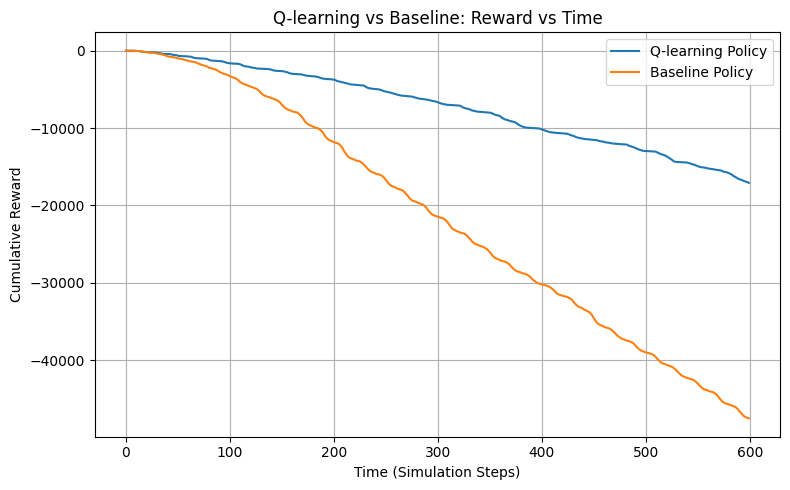

In [5]:


#comparing tthe q learning model and baseline model(Keeps the current phase for MIN_GREEN steps, Once MIN_GREEN is reached → switches phase,Repeats forever)

import traci
import pickle
import numpy as np
import matplotlib.pyplot as plt


SUMO_BINARY = r"C:\Program Files (x86)\Eclipse\Sumo\bin\sumo.exe"
SUMO_CFG = r"C:\Users\OMEN\Downloads\test\test1.sumocfg"
Q_PATH = r"q_table2.pkl"


MAX_STEPS = 600
MIN_GREEN = 5
SEED = 42   # same seed for fair comparison


# load q table 
with open(Q_PATH, "rb") as f:
    Q = pickle.load(f)

print(f"Loaded Q-table with {len(Q)} states")



def get_state(tls_id):
    lanes = traci.trafficlight.getControlledLanes(tls_id)
    flow1 = lanes[0::2]
    flow2 = lanes[1::2]

    X1 = sum(traci.lane.getLastStepHaltingNumber(l) for l in flow1)
    X2 = sum(traci.lane.getLastStepHaltingNumber(l) for l in flow2)
    L = traci.trafficlight.getPhase(tls_id)

    return (X1, X2, L)


def reward_fn(state):
    X1, X2, _ = state
    return -(X1**2 + X2**2)


# q-table policy
def q_action(state):
    if state not in Q:
        return 0
    return int(np.argmax(Q[state]))


#baseline policy
def baseline_action(step, last_switch):
    if (step - last_switch) >= MIN_GREEN:
        return 1
    return 0


def run_episode(policy="q"):
    traci.start([
        SUMO_BINARY,
        "-c", SUMO_CFG,
        "--seed", str(SEED),
        "--no-step-log",
        "--quit-on-end"
    ])

    tls_id = traci.trafficlight.getIDList()[0]
    num_phases = len(
        traci.trafficlight.getAllProgramLogics(tls_id)[0].phases
    )

    rewards = []
    cum_reward = 0
    last_switch = 0

    for step in range(MAX_STEPS):
        state = get_state(tls_id)

        if policy == "q":
            action = q_action(state)
        else:
            action = baseline_action(step, last_switch)

        if action == 1 and (step - last_switch) >= MIN_GREEN:
            phase = traci.trafficlight.getPhase(tls_id)
            traci.trafficlight.setPhase(
                tls_id,
                (phase + 1) % num_phases
            )
            last_switch = step

        traci.simulationStep()

        r = reward_fn(get_state(tls_id))
        cum_reward += r
        rewards.append(cum_reward)

        if traci.simulation.getMinExpectedNumber() == 0:
            break

    traci.close()
    return rewards

#running both policies
q_rewards = run_episode(policy="q")
base_rewards = run_episode(policy="baseline")


plt.figure(figsize=(8, 5))
plt.plot(q_rewards, label="Q-learning Policy")
plt.plot(base_rewards, label="Baseline Policy")
plt.xlabel("Time (Simulation Steps)")
plt.ylabel("Cumulative Reward")
plt.title("Q-learning vs Baseline: Reward vs Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


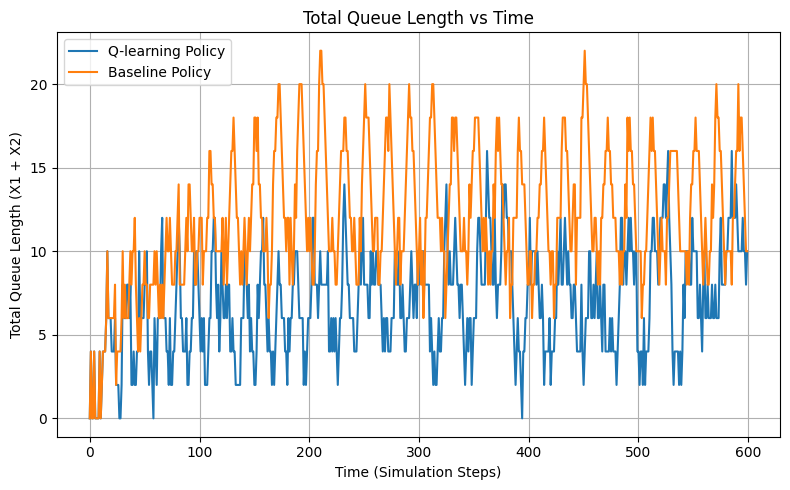

In [6]:
import traci
import pickle
import numpy as np
import matplotlib.pyplot as plt


SUMO_BINARY = r"C:\Program Files (x86)\Eclipse\Sumo\bin\sumo.exe"
SUMO_CFG = r"C:\Users\OMEN\Downloads\test\test1.sumocfg"
Q_PATH = r"q_table2.pkl"


MAX_STEPS = 600
MIN_GREEN = 5
SEED = 42   # same seed for fair comparison


with open(Q_PATH, "rb") as f:
    Q = pickle.load(f)


def get_state(tls_id):
    lanes = traci.trafficlight.getControlledLanes(tls_id)
    flow1 = lanes[0::2]
    flow2 = lanes[1::2]

    X1 = sum(traci.lane.getLastStepHaltingNumber(l) for l in flow1)
    X2 = sum(traci.lane.getLastStepHaltingNumber(l) for l in flow2)
    L = traci.trafficlight.getPhase(tls_id)

    return (X1, X2, L)


def q_action(state):
    if state not in Q:
        return 0
    return int(np.argmax(Q[state]))


def baseline_action(step, last_switch):
    if (step - last_switch) >= MIN_GREEN:
        return 1
    return 0


def run_episode(policy="q"):
    traci.start([
        SUMO_BINARY,
        "-c", SUMO_CFG,
        "--seed", str(SEED),
        "--no-step-log",
        "--quit-on-end"
    ])

    tls_id = traci.trafficlight.getIDList()[0]
    num_phases = len(
        traci.trafficlight.getAllProgramLogics(tls_id)[0].phases
    )

    queue_history = []
    last_switch = 0

    for step in range(MAX_STEPS):
        X1, X2, _ = get_state(tls_id)
        total_queue = X1 + X2
        queue_history.append(total_queue)

        if policy == "q":
            action = q_action((X1, X2, traci.trafficlight.getPhase(tls_id)))
        else:
            action = baseline_action(step, last_switch)

        if action == 1 and (step - last_switch) >= MIN_GREEN:
            phase = traci.trafficlight.getPhase(tls_id)
            traci.trafficlight.setPhase(
                tls_id,
                (phase + 1) % num_phases
            )
            last_switch = step

        traci.simulationStep()

        if traci.simulation.getMinExpectedNumber() == 0:
            break

    traci.close()
    return queue_history


q_queue = run_episode(policy="q")
baseline_queue = run_episode(policy="baseline")


plt.figure(figsize=(8, 5))
plt.plot(q_queue, label="Q-learning Policy")
plt.plot(baseline_queue, label="Baseline Policy")
plt.xlabel("Time (Simulation Steps)")
plt.ylabel("Total Queue Length (X1 + X2)")
plt.title("Total Queue Length vs Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
